# Conda environment

`conda create -n bluesv2 python=3.6 openmm=7.3.1 parmed=3.1.0 openmmtools=0.18.0 mdtraj pymbar seaborn nb_conda`


In [1]:
from simtk import openmm, unit
from openmmtools import alchemy
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import alchemy
from openmmtools.integrators import AlchemicalNonequilibriumLangevinIntegrator

import parmed
import mdtraj
import numpy
import abc
import copy
import math
import logging

# Energy unit used by OpenMM unit system
_OPENMM_ENERGY_UNIT = unit.kilojoules_per_mole

# Set a seed/random state
seed = numpy.random.seed(seed=3134)
random_state = numpy.random.RandomState(seed=3134)

/home/nathanlim/anaconda3/envs/bluesv2/lib/python3.6/site-packages/openmmtools/multistate/__init__.py:75: UserWarning: Warning: openmmtools.multistate API is experimental
  warnings.warn('Warning: openmmtools.multistate API is experimental')


In [2]:
def generateAlchSystem(system,
                       atom_indices,
                       softcore_alpha=0.5,
                       softcore_a=1,
                       softcore_b=1,
                       softcore_c=6,
                       softcore_beta=0.0,
                       softcore_d=1,
                       softcore_e=1,
                       softcore_f=2,
                       annihilate_electrostatics=True,
                       annihilate_sterics=False,
                       disable_alchemical_dispersion_correction=True,
                       alchemical_pme_treatment='direct-space',
                       suppress_warnings=True,
                       **kwargs):

    if suppress_warnings:
        #Lower logger level to suppress excess warnings
        logging.getLogger("openmmtools.alchemy").setLevel(logging.ERROR)

    #Disabled correction term due to increased computational cost
    factory = alchemy.AbsoluteAlchemicalFactory(
        disable_alchemical_dispersion_correction=disable_alchemical_dispersion_correction,
        alchemical_pme_treatment=alchemical_pme_treatment)
    alch_region = alchemy.AlchemicalRegion(
        alchemical_atoms=atom_indices,
        softcore_alpha=softcore_alpha,
        softcore_a=softcore_a,
        softcore_b=softcore_b,
        softcore_c=softcore_c,
        softcore_beta=softcore_beta,
        softcore_d=softcore_d,
        softcore_e=softcore_e,
        softcore_f=softcore_f,
        annihilate_electrostatics=annihilate_electrostatics,
        annihilate_sterics=annihilate_sterics)

    alch_system = factory.create_alchemical_system(system, alch_region)
    return alch_system

class AlchemicalExternalLangevinIntegrator(AlchemicalNonequilibriumLangevinIntegrator):
    """Allows nonequilibrium switching based on force parameters specified in alchemical_functions.
    A variable named lambda is switched from 0 to 1 linearly throughout the nsteps of the protocol.
    The functions can use this to create more complex protocols for other global parameters.
    As opposed to `openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator`,
    which this inherits from, the AlchemicalExternalLangevinIntegrator integrator also takes
    into account work done outside the nonequilibrium switching portion(between integration steps).
    For example if a molecule is rotated between integration steps, this integrator would
    correctly account for the work caused by that rotation.
    Propagator is based on Langevin splitting, as described below.
    One way to divide the Langevin system is into three parts which can each be solved "exactly:"
    - R: Linear "drift" / Constrained "drift"
        Deterministic update of *positions*, using current velocities
        ``x <- x + v dt``
    - V: Linear "kick" / Constrained "kick"
        Deterministic update of *velocities*, using current forces
        ``v <- v + (f/m) dt``; where f = force, m = mass
    - O: Ornstein-Uhlenbeck
        Stochastic update of velocities, simulating interaction with a heat bath
        ``v <- av + b sqrt(kT/m) R`` where:
        - a = e^(-gamma dt)
        - b = sqrt(1 - e^(-2gamma dt))
        - R is i.i.d. standard normal
    We can then construct integrators by solving each part for a certain timestep in sequence.
    (We can further split up the V step by force group, evaluating cheap but fast-fluctuating
    forces more frequently than expensive but slow-fluctuating forces. Since forces are only
    evaluated in the V step, we represent this by including in our "alphabet" V0, V1, ...)
    When the system contains holonomic constraints, these steps are confined to the constraint
    manifold.
    Parameters
    ----------
    alchemical_functions : dict of strings
        key: value pairs such as "global_parameter" : function_of_lambda where function_of_lambda is a Lepton-compatible string that depends on the variable "lambda"
    splitting : string, default: "H V R O V R H"
        Sequence of R, V, O (and optionally V{i}), and { }substeps to be executed each timestep. There is also an H option, which increments the global parameter `lambda` by 1/nsteps_neq for each step.
        Forces are only used in V-step. Handle multiple force groups by appending the force group index
        to V-steps, e.g. "V0" will only use forces from force group 0. "V" will perform a step using all forces.( will cause metropolization, and must be followed later by a ).
    temperature : numpy.unit.Quantity compatible with kelvin, default: 298.0*simtk.unit.kelvin
       Fictitious "bath" temperature
    collision_rate : numpy.unit.Quantity compatible with 1/picoseconds, default: 91.0/simtk.unit.picoseconds
       Collision rate
    timestep : numpy.unit.Quantity compatible with femtoseconds, default: 1.0*simtk.unit.femtoseconds
       Integration timestep
    constraint_tolerance : float, default: 1.0e-8
        Tolerance for constraint solver
    measure_shadow_work : boolean, default: False
        Accumulate the shadow work performed by the symplectic substeps, in the global `shadow_work`
    measure_heat : boolean, default: True
        Accumulate the heat exchanged with the bath in each step, in the global `heat`
    nsteps_neq : int, default: 100
        Number of steps in nonequilibrium protocol. Default 100
    prop_lambda : float (Default = 0.3)
        Defines the region in which to add extra propagation
        steps during the NCMC simulation from the midpoint 0.5.
        i.e. A value of 0.3 will add extra steps from lambda 0.2 to 0.8.
    nprop : int (Default: 1)
        Controls the number of propagation steps to add in the lambda
        region defined by `prop_lambda`.
    Attributes
    ----------
    _kinetic_energy : str
        This is 0.5*m*v*v by default, and is the expression used for the kinetic energy
    Examples
    --------
    - g-BAOAB:
        splitting="R V O H O V R"
    - VVVR
        splitting="O V R H R V O"
    - VV
        splitting="V R H R V"
    - An NCMC algorithm with Metropolized integrator:
        splitting="O { V R H R V } O"
    References
    ----------
    [Nilmeier, et al. 2011] Nonequilibrium candidate Monte Carlo is an efficient tool for equilibrium simulation
    [Leimkuhler and Matthews, 2015] Molecular dynamics: with deterministic and stochastic numerical methods, Chapter 7
    """

    def __init__(self,
                 alchemical_functions,
                 splitting="R V O H O V R",
                 temperature=298.0 * unit.kelvin,
                 collision_rate=1.0 / unit.picoseconds,
                 timestep=1.0 * unit.femtoseconds,
                 constraint_tolerance=1e-8,
                 measure_shadow_work=False,
                 measure_heat=True,
                 nsteps_neq=100,
                 nprop=1,
                 prop_lambda=0.3,
                 *args,
                 **kwargs):
        # call the base class constructor
        super(AlchemicalExternalLangevinIntegrator, self).__init__(
            alchemical_functions=alchemical_functions,
            splitting=splitting,
            temperature=temperature,
            collision_rate=collision_rate,
            timestep=timestep,
            constraint_tolerance=constraint_tolerance,
            measure_shadow_work=measure_shadow_work,
            measure_heat=measure_heat,
            nsteps_neq=nsteps_neq)

        self._prop_lambda = self._get_prop_lambda(prop_lambda)

        # add some global variables relevant to the integrator
        kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
        kT = kB * temperature
        self.addGlobalVariable("perturbed_pe", 0)
        self.addGlobalVariable("unperturbed_pe", 0)
        self.addGlobalVariable("first_step", 0)
        self.addGlobalVariable("nprop", nprop)
        self.addGlobalVariable("prop", 1)
        self.addGlobalVariable("prop_lambda_min", self._prop_lambda[0])
        self.addGlobalVariable("prop_lambda_max", self._prop_lambda[1])
        # Behavior changed in https://github.com/choderalab/openmmtools/commit/7c2630050631e126d61b67f56e941de429b2d643#diff-5ce4bc8893e544833c827299a5d48b0d
        self._step_dispatch_table['H'] = (self._add_alchemical_perturbation_step, False)
        #$self._registered_step_types['H'] = (
        #    self._add_alchemical_perturbation_step, False)
        self.addGlobalVariable("debug", 0)

        try:
            self.getGlobalVariableByName("shadow_work")
        except:
            self.addGlobalVariable('shadow_work', 0)

    def _get_prop_lambda(self, prop_lambda):
        prop_lambda_max = round(prop_lambda + 0.5, 4)
        prop_lambda_min = round(0.5 - prop_lambda, 4)
        prop_range = prop_lambda_max - prop_lambda_min

        #Set values to outside [0, 1.0] to skip IfBlock
        if prop_range <= 0.0:
            prop_lambda_min = 2.0
            prop_lambda_max = -1.0

        return prop_lambda_min, prop_lambda_max

    def _add_integrator_steps(self):
        """
        Override the base class to insert reset steps around the integrator.
        """

        # First step: Constrain positions and velocities and reset work accumulators and alchemical integrators
        self.beginIfBlock('step = 0')
        self.addComputeGlobal("perturbed_pe", "energy")
        self.addComputeGlobal("unperturbed_pe", "energy")
        self.addConstrainPositions()
        self.addConstrainVelocities()
        self._add_reset_protocol_work_step()
        self._add_alchemical_reset_step()
        self.endBlock()

        # Main body
        if self._n_steps_neq == 0:
            # If nsteps = 0, we need to force execution on the first step only.
            self.beginIfBlock('step = 0')
            super(AlchemicalNonequilibriumLangevinIntegrator, self)._add_integrator_steps()
            self.addComputeGlobal("step", "step + 1")
            self.endBlock()
        else:
            #call the superclass function to insert the appropriate steps, provided the step number is less than n_steps
            self.beginIfBlock("step < nsteps")
            self.addComputeGlobal("perturbed_pe", "energy")
            self.beginIfBlock("first_step < 1")
            #TODO write better test that checks that the initial work isn't gigantic
            self.addComputeGlobal("first_step", "1")
            self.addComputeGlobal("unperturbed_pe", "energy")
            self.endBlock()
            #initial iteration
            self.addComputeGlobal("protocol_work", "protocol_work + (perturbed_pe - unperturbed_pe)")
            super(AlchemicalNonequilibriumLangevinIntegrator, self)._add_integrator_steps()
            #if more propogation steps are requested
            self.beginIfBlock("lambda > prop_lambda_min")
            self.beginIfBlock("lambda <= prop_lambda_max")

            self.beginWhileBlock("prop < nprop")
            self.addComputeGlobal("prop", "prop + 1")

            super(AlchemicalNonequilibriumLangevinIntegrator, self)._add_integrator_steps()
            self.endBlock()
            self.endBlock()
            self.endBlock()
            #ending variables to reset
            self.addComputeGlobal("unperturbed_pe", "energy")
            self.addComputeGlobal("step", "step + 1")
            self.addComputeGlobal("prop", "1")

            self.endBlock()

    def _add_alchemical_perturbation_step(self):
        """
        Add alchemical perturbation step, accumulating protocol work.
        TODO: Extend this to be able to handle force groups?
        """
        # Store initial potential energy
        self.beginIfBlock("prop = 1")
        self.addComputeGlobal("debug", "debug + 1")
        self.addComputeGlobal("Eold", "energy")

        # Update lambda and increment that tracks updates.
        self.addComputeGlobal('lambda', '(lambda_step+1)/n_lambda_steps')
        self.addComputeGlobal('lambda_step', 'lambda_step + 1')

        # Update all slaved alchemical parameters
        self._add_update_alchemical_parameters_step()

        # Accumulate protocol work
        self.addComputeGlobal("Enew", "energy")
        self.addComputeGlobal("protocol_work", "protocol_work + (Enew-Eold)")
        self.endBlock()

    def getLogAcceptanceProbability(self, context):
        #TODO remove context from arguments if/once ncmc_switching is changed
        protocol = self.getGlobalVariableByName("protocol_work")
        shadow = self.getGlobalVariableByName("shadow_work")
        logp_accept = -1.0 * (protocol + shadow) * _OPENMM_ENERGY_UNIT / self.kT
        return logp_accept

    def reset(self):
        self.setGlobalVariableByName("step", 0)
        self.setGlobalVariableByName("lambda", 0.0)
        self.setGlobalVariableByName("protocol_work", 0.0)
        self.setGlobalVariableByName("shadow_work", 0.0)
        self.setGlobalVariableByName("first_step", 0)
        self.setGlobalVariableByName("perturbed_pe", 0.0)
        self.setGlobalVariableByName("unperturbed_pe", 0.0)
        self.setGlobalVariableByName("prop", 1)
        super(AlchemicalExternalLangevinIntegrator, self).reset()

In [3]:
class RandomLigandRotationMove():

    def __init__(self, structure, resname='LIG', random_state=None):
        self.structure = structure
        self.resname = resname
        self.random_state = random_state
        self.atom_indices = self.getAtomIndices(structure, self.resname)
        self.topology = structure[self.atom_indices].topology
        self.totalmass = 0
        self.masses = []

        self.center_of_mass = None
        self.positions = structure[self.atom_indices].positions
        self._calculateProperties()

    def getAtomIndices(self, structure, resname):
        """
        Get atom indices of a ligand from ParmEd Structure.
        Parameters
        ----------
        resname : str
            String specifying the residue name of the ligand.
        structure: parmed.Structure
            ParmEd Structure object of the atoms to be moved.
        Returns
        -------
        atom_indices : list of ints
            list of atoms in the coordinate file matching lig_resname
        """
        # TODO: Add option for resnum to better select residue names
        atom_indices = []
        topology = structure.topology
        for atom in topology.atoms():
            if str(resname) in atom.residue.name:
                atom_indices.append(atom.index)
        return atom_indices

    def getMasses(self, topology):
        """
        Returns a list of masses of the specified ligand atoms.
        Parameters
        ----------
        topology: parmed.Topology
            ParmEd topology object containing atoms of the system.
        Returns
        -------
        masses: 1xn numpy.array * simtk.unit.dalton
            array of masses of len(self.atom_indices), denoting
            the masses of the atoms in self.atom_indices
        totalmass: float * simtk.unit.dalton
            The sum of the mass found in masses
        """
        masses = unit.Quantity(numpy.zeros([int(topology.getNumAtoms()), 1], numpy.float32), unit.dalton)
        for idx, atom in enumerate(topology.atoms()):
            masses[idx] = atom.element._mass
        totalmass = masses.sum()
        return masses, totalmass

    def getCenterOfMass(self, positions, masses):
        """Returns the calculated center of mass of the ligand as a numpy.array
        Parameters
        ----------
        positions: nx3 numpy array * simtk.unit compatible with simtk.unit.nanometers
            ParmEd positions of the atoms to be moved.
        masses : numpy.array
            numpy.array of particle masses
        Returns
        -------
        center_of_mass: numpy array * simtk.unit compatible with simtk.unit.nanometers
            1x3 numpy.array of the center of mass of the given positions
        """
        coordinates = numpy.asarray(positions._value, numpy.float32)
        center_of_mass = parmed.geometry.center_of_mass(coordinates, masses) * positions.unit
        return center_of_mass

    def _calculateProperties(self):
        """Calculate the masses and center of mass for the object. This function
        is called upon initailization of the class."""
        self.masses, self.totalmass = self.getMasses(self.topology)
        self.center_of_mass = self.getCenterOfMass(self.positions, self.masses)

    def move(self, context, verbose=True):
        """Function that performs a random rotation about the
        center of mass of the ligand.
        Parameters
        ----------
        context: simtk.openmm.Context object
            Context containing the positions to be moved.
        Returns
        -------
        context: simtk.openmm.Context object
            The same input context, but whose positions were changed by this function.
        """
        positions = context.getState(getPositions=True).getPositions(asNumpy=True)

        self.positions = positions[self.atom_indices]
        
        
        if verbose: print('Current Positions:', self.positions)
        self.center_of_mass = self.getCenterOfMass(self.positions, self.masses)
        reduced_pos = self.positions - self.center_of_mass

        # Define random rotational move on the ligand
        rand_quat = mdtraj.utils.uniform_quaternion(size=None, random_state=self.random_state)
        rand_rotation_matrix = mdtraj.utils.rotation_matrix_from_quaternion(rand_quat)
        Tr = numpy.trace(rand_rotation_matrix)
        theta = numpy.arccos((Tr - 1)/2)
        if verbose: print('Theta = %s' % theta)
        #multiply lig coordinates by rot matrix and add back COM translation from origin
        rot_move = numpy.dot(reduced_pos, rand_rotation_matrix) * positions.unit + self.center_of_mass

        # Update ligand positions in nc_sim
        for index, atomidx in enumerate(self.atom_indices):
            positions[atomidx] = rot_move[index]
        context.setPositions(positions)
        positions = context.getState(getPositions=True).getPositions(asNumpy=True)
        
        self.positions = positions[self.atom_indices] 
        if verbose: print('Proposed Positions:', self.positions)

        return context, theta

In [4]:
def queryContext(context):
    integrator_variables = ['lambda', 'protocol_work']
    integrator_data = {}
    for name in integrator_variables:
        var = context._integrator.getGlobalVariableByName(name)
        integrator_data[name] = var
    integrator_data['logP'] = context._integrator.getLogAcceptanceProbability(context)
    return integrator_data

In [5]:
# Set Simulation parameters
temperature = 200 * unit.kelvin
collision_rate = 1 / unit.picoseconds
timestep = 1.0 * unit.femtoseconds
n_steps = 10
alchemical_atoms = [0,1]
alchemical_functions = {
    'lambda_sterics': 'min(1, (1/0.3)*abs(lambda-0.5))',
    'lambda_electrostatics': 'step(0.2-lambda) - 1/0.2*lambda*step(0.2-lambda) + 1/0.2*(lambda-0.8)*step(lambda-0.8)'
}

In [6]:
# Load our OpenMM System and create Integrator
with open('ethylene_system.xml', 'r') as infile:
    xml = infile.read()
    system = openmm.XmlSerializer.deserialize(xml)
alch_system = generateAlchSystem(system, alchemical_atoms)
alch_integrator = AlchemicalExternalLangevinIntegrator(nsteps_neq=n_steps,
            alchemical_functions=alchemical_functions,   
            splitting="H V R O R V H",
            temperature=temperature,
            timestep=timestep)
alch_integrator.setRandomNumberSeed(3134)

In [7]:
# Load a Parmed Structure for the Topology
# Create our States
structure = parmed.load_file('../sgill_testsystem/ethlyene_structure.pdb')
platform = openmm.Platform.getPlatformByName('CPU')
alch_state = alchemy.AlchemicalState.from_system(alch_system)
alch_thermodynamic_state = ThermodynamicState(alch_system, temperature)
alch_thermodynamic_state = CompoundThermodynamicState(alch_thermodynamic_state,
                                                     composable_states=[alch_state])
#Attach a topology for convenience
alch_thermodynamic_state.topology = structure.topology
sampler_state = SamplerState(positions=structure.positions.in_units_of(unit.nanometers))

# Create a Context from our States
context = alch_thermodynamic_state.create_context(alch_integrator)

# Set initial Positions and Velocities
sampler_state.apply_to_context(context)
context.setVelocitiesToTemperature(temperature,3134)

# Initialize our move proposal class
rot_move = RandomLigandRotationMove(structure, 'TMP', random_state)

In [8]:
def runSimulation(context, sampler_state, 
                  stats, rot_move=None, verbose=True):
    
    # Store initial positions
    initial_positions = context.getState(getPositions=True).getPositions()
      
    for i in range(n_steps):
        context._integrator.step(1)

        #Propose move at lambda=0.5 (elec/sterics=0)
        if i == n_steps/2 and rot_move:
            context, stats['theta'] = rot_move.move(context, verbose)           
            
    integrator_data = queryContext(context)
    # Store integrator data into stats dict
    stats['work'] = integrator_data['protocol_work']
    stats['logP'] = integrator_data['logP']

    #Metropolization step
    randnum = math.log(numpy.random.random())
    if stats['logP'] > randnum:
        if verbose: print('ACCEPT' , stats['logP'])
        stats['accept']+=1
    else:
        if verbose: print('REJECT', stats['logP'])
        #Reset the positions if we reject
        sampler_state.positions = initial_positions
        sampler_state.apply_to_context(context)
        
    #Determine which binding mode we are in
    # Check distance between particle 0 and 2
    positions = context.getState(getPositions=True).getPositions(asNumpy=True)
    particle0 = positions[0]
    particle2 = positions[2]
    stats['dist'] = numpy.sqrt(numpy.sum(particle0 - particle2)**2)
    
    if stats['dist'] <= 0.49:
        stats['bm'] = 0
    else:
        stats['bm'] = 1
        
    #Reset for the next iteration
    context._integrator.reset()
    context.setVelocitiesToTemperature(temperature, 3134)    
    stats['iter']+=1
    
    return context, sampler_state, stats

In [9]:
%%time 
n_iter = 50000
#Initialize dict to store some stats
stats = {'iter' : 0, 'accept' : 0, 'theta' : 0, 'work' : 0, 'logP' : 0, 'dist' : 0, 'bm' : 0}
file = open('bluesv2-debug0.txt', 'w')
print('iter,accept,theta,work,logP,dist,bm', file=file)
for n in range(n_iter):
    context, sampler_state, stats = runSimulation(context, sampler_state, stats, 
                                                  rot_move, verbose=False)
    output = '{iter},{accept},{theta},{work},{logP},{dist},{bm}'.format(**stats)
    print(output, file=file)
file.close()

CPU times: user 2min 51s, sys: 1min 1s, total: 3min 53s
Wall time: 5min 45s


# Analyze the work distributions

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#'Iter,Accept,Theta,Work,LogP,Dist,State'

In [11]:
v1 = pd.read_csv('bluesv1-debug0.txt', skipfooter=1)
v2 = pd.read_csv('bluesv2-debug0.txt', skipfooter=1)

/home/nathanlim/anaconda3/envs/bluesv2/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/nathanlim/anaconda3/envs/bluesv2/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


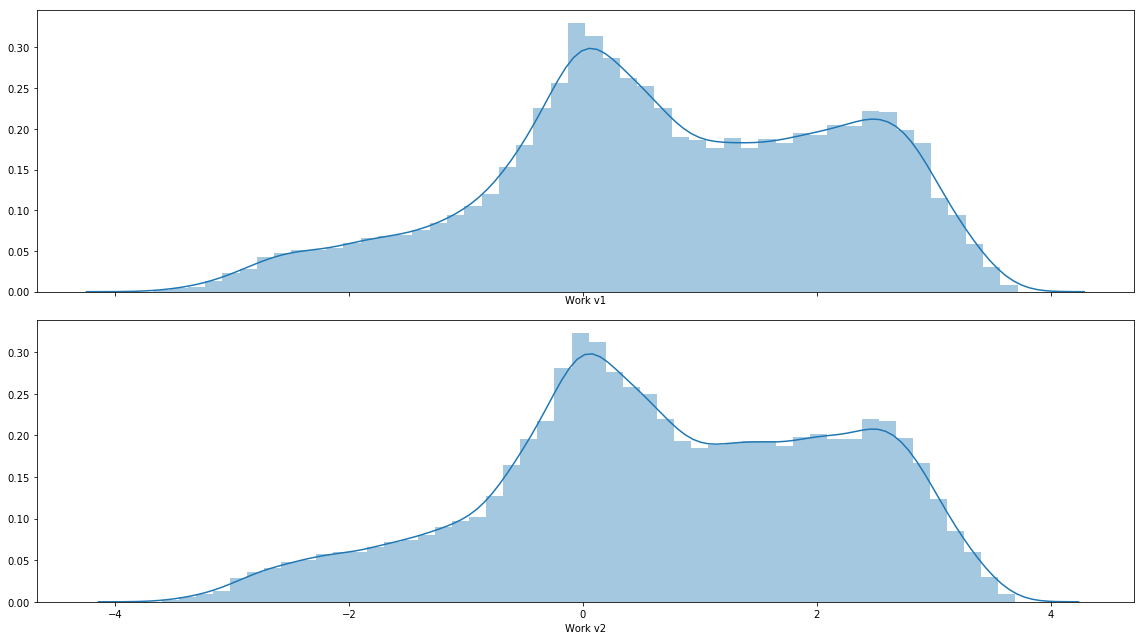

In [12]:
fig, ax = plt.subplots(2, figsize=(16,9), sharex=True)
sns.distplot(v1['work'], ax=ax[0], axlabel='Work v1')
sns.distplot(v2['work'], ax=ax[1], axlabel='Work v2')
fig.tight_layout()